# Exploring the perfect place in NYC to open the Hip Japanese Restaurant

First, let's import all needed libraries.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


<br>
<br>

In NYC, there are several neighborhoods among 5 boroughs.<br>
Using a public data below, I'll get the geographic data for NYC.  

the dataset:<br>
[https://geo.nyu.edu/catalog/nyu_2451_34572](https://geo.nyu.edu/catalog/nyu_2451_34572?cm_mmc=Email_Newsletter-_-Developer_Ed%2BTech-_-WW_WW-_-SkillsNetwork-Courses-IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork-21253531&cm_mmca1=000026UJ&cm_mmca2=10006555&cm_mmca3=M12345678&cvosrc=email.Newsletter.M12345678&cvo_campaign=000026UJ&cm_mmc=Email_Newsletter-_-Developer_Ed%2BTech-_-WW_WW-_-SkillsNetwork-Courses-IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork-21253531&cm_mmca1=000026UJ&cm_mmca2=10006555&cm_mmca3=M12345678&cvosrc=email.Newsletter.M12345678&cvo_campaign=000026UJ)


In [2]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
neighborhoods_data = newyork_data['features']

Transform the data to the dataframe using pandas.

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

And fill the dataframe.

In [6]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [7]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


<br>

Create a map of NYC with neighborhoods.

In [8]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [9]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

Then, we will use Folium to explore the dataset more.<br>
But before that, to simplify the dataset, I will slice the data and create new dataframe of Manhattan and Brooklyn.

In [10]:
nyc_data = neighborhoods[(neighborhoods['Borough'] == 'Manhattan')|(neighborhoods['Borough'] == 'Brooklyn')].reset_index(drop=True)
nyc_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Brooklyn,Bay Ridge,40.625801,-74.030621
2,Brooklyn,Bensonhurst,40.611009,-73.995180
3,Brooklyn,Sunset Park,40.645103,-74.010316
4,Brooklyn,Greenpoint,40.730201,-73.954241


In [11]:
address = 'NYC'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of NYC are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of NYC are 40.7127281, -74.0060152.


In [12]:
# create map of Manhattan and Brooklyn using latitude and longitude values
map_nyc = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(nyc_data['Latitude'], nyc_data['Longitude'], nyc_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nyc)  
    
map_nyc

Next, let's utilize the Foursquare API.

First step, defining the Credentials and version.

In [13]:
CLIENT_ID = '4NSNVM5VC1VJRAZAFJ0FHMS23XAWUL32QZXGWS1CDR5PRT1R' # your Foursquare ID
CLIENT_SECRET = 'CKQBA1VW21ZUJ1X3JQRC4RC2YWUIBCUIFVFWDGVNSW3N3JP1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 4NSNVM5VC1VJRAZAFJ0FHMS23XAWUL32QZXGWS1CDR5PRT1R
CLIENT_SECRET:CKQBA1VW21ZUJ1X3JQRC4RC2YWUIBCUIFVFWDGVNSW3N3JP1


Combine venues data and neighborhoods data.

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
nyc_venues = getNearbyVenues(names=nyc_data['Neighborhood'],
                                   latitudes=nyc_data['Latitude'],
                                   longitudes=nyc_data['Longitude']
                                  )

Marble Hill
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho

In [16]:
print(nyc_venues.shape)
nyc_venues.head()

(5968, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


Let's check how many venues were returned for each neighborhood

In [17]:
nyc_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bath Beach,46,46,46,46,46,46
Battery Park City,66,66,66,66,66,66
Bay Ridge,81,81,81,81,81,81
Bedford Stuyvesant,28,28,28,28,28,28
Bensonhurst,36,36,36,36,36,36
Bergen Beach,7,7,7,7,7,7
Boerum Hill,90,90,90,90,90,90
Borough Park,22,22,22,22,22,22
Brighton Beach,43,43,43,43,43,43


In [18]:
print('There are {} uniques categories.'.format(len(nyc_venues['Venue Category'].unique())))

There are 378 uniques categories.


# Let's analyse each Neighborhood

In [19]:
# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nyc_onehot['Neighborhood'] = nyc_venues['Neighborhood'] 

# move neighborhood column to the first column
col_name="Neighborhood"
first_col = nyc_onehot.pop(col_name)
nyc_onehot.insert(0, col_name, first_col)

nyc_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Outlet Store,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Piercing Parlor,Pilates Studio,Pizza Place,Play

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [20]:
nyc_grouped = nyc_onehot.groupby('Neighborhood').mean().reset_index()
nyc_grouped

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Outlet Store,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Piercing Parlor,Pilates Studio,Pizza Place,Play

Let's confirm the size:

In [21]:
nyc_grouped.shape

(110, 378)

5 Top common value in each Neighborhood

In [22]:
num_top_venues = 5

for hood in nyc_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = nyc_grouped[nyc_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bath Beach----
                  venue  freq
0          Dessert Shop  0.04
1    Italian Restaurant  0.04
2  Cantonese Restaurant  0.04
3           Gas Station  0.04
4    Chinese Restaurant  0.04


----Battery Park City----
           venue  freq
0           Park  0.09
1          Hotel  0.08
2    Coffee Shop  0.06
3            Gym  0.06
4  Memorial Site  0.05


----Bay Ridge----
                 venue  freq
0   Italian Restaurant  0.07
1                  Spa  0.06
2          Pizza Place  0.05
3  American Restaurant  0.04
4                  Bar  0.04


----Bedford Stuyvesant----
          venue  freq
0   Coffee Shop  0.11
1          Café  0.07
2           Bar  0.07
3   Pizza Place  0.07
4  Gourmet Shop  0.04


----Bensonhurst----
                venue  freq
0  Chinese Restaurant  0.11
1  Italian Restaurant  0.08
2          Donut Shop  0.06
3      Ice Cream Shop  0.06
4         Pizza Place  0.06


----Bergen Beach----
             venue  freq
0  Harbor / Marina  0.29
1       Playgroun

Retrieve Top 10 common venues of each Neighborhood.

In [71]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [72]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nyc_grouped['Neighborhood']

for ind in np.arange(nyc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bath Beach,Dessert Shop,Pizza Place,Pharmacy,Gas Station,Donut Shop,Italian Restaurant,Bubble Tea Shop,Cantonese Restaurant,Chinese Restaurant,Fast Food Restaurant
1,Battery Park City,Park,Hotel,Coffee Shop,Gym,Memorial Site,Plaza,Burger Joint,Playground,Shopping Mall,Gourmet Shop
2,Bay Ridge,Italian Restaurant,Spa,Pizza Place,Greek Restaurant,American Restaurant,Bar,Bagel Shop,Café,Sushi Restaurant,Thai Restaurant
3,Bedford Stuyvesant,Coffee Shop,Café,Pizza Place,Bar,Park,BBQ Joint,Fried Chicken Joint,New American Restaurant,Boutique,Gift Shop
4,Bensonhurst,Chinese Restaurant,Italian Restaurant,Ice Cream Shop,Sushi Restaurant,Donut Shop,Park,Pizza Place,Grocery Store,Record Shop,Coffee Shop


To narrow down the dataset, we will create clusters using calculated suited k-means.

In [73]:
nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)

In [74]:
sum_of_squared_distances = []
K = range(1,50)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(nyc_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

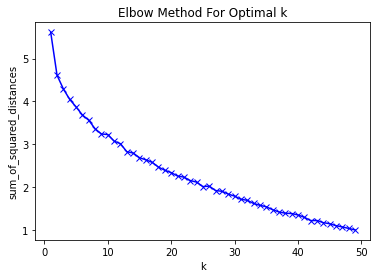

In [75]:
import matplotlib.pyplot as plt

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');

In [76]:
from sklearn.metrics import silhouette_score

sil = []
K_sil = range(2,50)
# minimum 2 clusters required, to define dissimilarity
for k in K_sil:
    print(k, end=' ')
    kmeans = KMeans(n_clusters = k).fit(nyc_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(nyc_grouped_clustering, labels, metric = 'euclidean'))

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

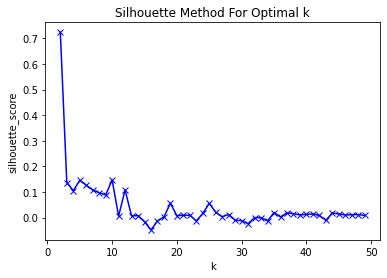

In [77]:
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()

There are peaks at k=2, k=5, and k=10.<br>
The peaks of k=2 and k=5 will give a very broad classification of the venues, so it seems k=10 is the best number of clusters. <br>
Let's see clusters on a map!

In [78]:
# set number of clusters
kclusters = 10

nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([5, 1, 5, 1, 5, 0, 1, 3, 5, 7], dtype=int32)

In [79]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

nyc_merged = nyc_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
nyc_merged = nyc_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

nyc_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,1,Sandwich Place,Coffee Shop,Gym,Discount Store,Video Game Store,Supplement Shop,Donut Shop,Pharmacy,Kids Store,Steakhouse
1,Brooklyn,Bay Ridge,40.625801,-74.030621,5,Italian Restaurant,Spa,Pizza Place,Greek Restaurant,American Restaurant,Bar,Bagel Shop,Café,Sushi Restaurant,Thai Restaurant
2,Brooklyn,Bensonhurst,40.611009,-73.995180,5,Chinese Restaurant,Italian Restaurant,Ice Cream Shop,Sushi Restaurant,Donut Shop,Park,Pizza Place,Grocery Store,Record Shop,Coffee Shop
3,Brooklyn,Sunset Park,40.645103,-74.010316,7,Latin American Restaurant,Pizza Place,Mobile Phone Shop,Mexican Restaurant,Bank,Bakery,Ice Cream Shop,Fried Chicken Joint,Gym,Deli / Bodega
4,Brooklyn,Greenpoint,40.730201,-73.954241,1,Bar,Pizza Place,Coffee Shop,Cocktail Bar,Yoga Studio,Deli / Bodega,Record Shop,French Restaurant,Mexican Restaurant,Sandwich Place


In [80]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], nyc_merged['Neighborhood'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now let's take a look at the contents of each cluster.

### Cluster0

In [81]:
required_column_indices = [0,5,6]
required_column = [list(nyc_merged.columns.values)[i] for i in required_column_indices]
required_column_indices = [0,5,6]

In [82]:
cluster_0 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 0, nyc_merged.columns[0:12]]
cluster_0.head(5)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
38,Brooklyn,Marine Park,40.609748,-73.931344,0,Park,Basketball Court,Deli / Bodega,Baseball Field,Ice Cream Shop,Chinese Restaurant,Pizza Place
44,Brooklyn,Ocean Hill,40.678403,-73.913068,0,Deli / Bodega,Bus Stop,Southern / Soul Food Restaurant,Supermarket,Grocery Store,Salad Place,Bakery
46,Brooklyn,Bergen Beach,40.615150,-73.898556,0,Harbor / Marina,Baseball Field,Playground,Park,Hockey Field,Athletics & Sports,Food & Drink Shop
65,Manhattan,Roosevelt Island,40.762160,-73.949168,0,Deli / Bodega,Plaza,School,Coffee Shop,Park,Gym / Fitness Center,Gym


In [83]:
for col in required_column:
    print(cluster_0[col].value_counts(ascending = False))
    print("---------------------------------------------")

Brooklyn     3
Manhattan    1
Name: Borough, dtype: int64
---------------------------------------------
Deli / Bodega      2
Harbor / Marina    1
Park               1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Basketball Court    1
Baseball Field      1
Bus Stop            1
Plaza               1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------


There are many playgrounds, delis and supermarkets in the area, which makes it a residential area.

### Cluster1

In [84]:
cluster_1 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 1, nyc_merged.columns[0:12]]
cluster_1.head(5)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,1,Sandwich Place,Coffee Shop,Gym,Discount Store,Video Game Store,Supplement Shop,Donut Shop
4,Brooklyn,Greenpoint,40.730201,-73.954241,1,Bar,Pizza Place,Coffee Shop,Cocktail Bar,Yoga Studio,Deli / Bodega,Record Shop
16,Brooklyn,Williamsburg,40.707144,-73.958115,1,Coffee Shop,Bagel Shop,Yoga Studio,Gym,Bar,Park,Café
17,Brooklyn,Bushwick,40.698116,-73.925258,1,Bar,Mexican Restaurant,Coffee Shop,Deli / Bodega,Discount Store,Bakery,Thrift / Vintage Store
18,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,1,Coffee Shop,Café,Pizza Place,Bar,Park,BBQ Joint,Fried Chicken Joint


In [85]:
for col in required_column:
    print(cluster_1[col].value_counts(ascending = False))
    print("---------------------------------------------")

Manhattan    23
Brooklyn     17
Name: Borough, dtype: int64
---------------------------------------------
Coffee Shop             10
Park                     6
Italian Restaurant       4
Bar                      2
Gym / Fitness Center     2
Seafood Restaurant       2
Mexican Restaurant       1
Café                     1
Hotel                    1
Burger Joint             1
Food Truck               1
Dance Studio             1
Discount Store           1
African Restaurant       1
Korean Restaurant        1
Pizza Place              1
Deli / Bodega            1
Theater                  1
Sandwich Place           1
Sports Club              1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Coffee Shop               6
Café                      5
Bar                       4
American Restaurant       4
Hotel                     3
Pizza Place               2
Bagel Shop                1
Bookstore                 1
Exhibit                   1
Burger Joint  

The large number of coffee shops, restaurants, bars, and hotels seems like a good fit for the criteria, but there are too many areas, so we need to narrow down the target further.

### Cluster2

In [86]:
cluster_2 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 2, nyc_merged.columns[0:12]]
cluster_2.head(5)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
31,Brooklyn,Mill Island,40.606336,-73.908186,2,Pool,Yoga Studio,Fish Market,Exhibit,Factory,Falafel Restaurant,Farm


In [87]:
for col in required_column:
    print(cluster_2[col].value_counts(ascending = False))
    print("---------------------------------------------")

Brooklyn    1
Name: Borough, dtype: int64
---------------------------------------------
Pool    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Yoga Studio    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------


Same as cluster0, we can say this neighborhood is a residential area.

### Cluster3

In [88]:
cluster_3 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 3, nyc_merged.columns[0:12]]
cluster_3.head(5)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
10,Brooklyn,Crown Heights,40.670829,-73.943291,3,Pizza Place,Museum,Café,Bakery,Kosher Restaurant,Moving Target,Candy Store
35,Brooklyn,Borough Park,40.633131,-73.990498,3,Bank,Pizza Place,Fast Food Restaurant,Café,Pharmacy,Eastern European Restaurant,Restaurant
47,Brooklyn,Midwood,40.625596,-73.957595,3,Pizza Place,Ice Cream Shop,Bakery,Bagel Shop,Video Game Store,Convenience Store,Field
53,Brooklyn,Ocean Parkway,40.613060,-73.968367,3,Pizza Place,Liquor Store,Sushi Restaurant,Paper / Office Supplies Store,Bagel Shop,Gym,Health & Beauty Service


In [89]:
for col in required_column:
    print(cluster_3[col].value_counts(ascending = False))
    print("---------------------------------------------")

Brooklyn    4
Name: Borough, dtype: int64
---------------------------------------------
Pizza Place    3
Bank           1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Liquor Store      1
Pizza Place       1
Ice Cream Shop    1
Museum            1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------


This area doesn't seem to fit the criteria because there are a lot of commercial establishments for residents in the area.

### Cluster4

In [90]:
cluster_4 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 4, nyc_merged.columns[0:12]]
cluster_4.head(5)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
93,Brooklyn,Paerdegat Basin,40.631318,-73.902335,4,Asian Restaurant,Child Care Service,Auto Garage,Food,Fish Market,Factory,Falafel Restaurant


In [91]:
for col in required_column:
    print(cluster_4[col].value_counts(ascending = False))
    print("---------------------------------------------")

Brooklyn    1
Name: Borough, dtype: int64
---------------------------------------------
Asian Restaurant    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Child Care Service    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------


We can say this neighborhood is a residential area.

### Cluster5

In [92]:
cluster_5 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 5, nyc_merged.columns[0:12]]
cluster_5.head(5)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
1,Brooklyn,Bay Ridge,40.625801,-74.030621,5,Italian Restaurant,Spa,Pizza Place,Greek Restaurant,American Restaurant,Bar,Bagel Shop
2,Brooklyn,Bensonhurst,40.611009,-73.995180,5,Chinese Restaurant,Italian Restaurant,Ice Cream Shop,Sushi Restaurant,Donut Shop,Park,Pizza Place
5,Brooklyn,Gravesend,40.595260,-73.973471,5,Lounge,Pizza Place,Bakery,Gym,Italian Restaurant,Chinese Restaurant,Cosmetics Shop
6,Brooklyn,Brighton Beach,40.576825,-73.965094,5,Eastern European Restaurant,Russian Restaurant,Restaurant,Pharmacy,Beach,Gourmet Shop,Sushi Restaurant
7,Brooklyn,Sheepshead Bay,40.586890,-73.943186,5,Dessert Shop,Turkish Restaurant,Sandwich Place,Yoga Studio,Karaoke Bar,Outlet Store,Harbor / Marina


In [93]:
for col in required_column:
    print(cluster_5[col].value_counts(ascending = False))
    print("---------------------------------------------")

Brooklyn     22
Manhattan    16
Name: Borough, dtype: int64
---------------------------------------------
Italian Restaurant             10
Bar                             5
Chinese Restaurant              4
Mexican Restaurant              2
Dessert Shop                    2
Café                            2
Plaza                           2
Eastern European Restaurant     1
Burger Joint                    1
Pizza Place                     1
Bakery                          1
Deli / Bodega                   1
Coffee Shop                     1
Grocery Store                   1
Moving Target                   1
Bagel Shop                      1
Clothing Store                  1
Lounge                          1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Pizza Place                8
Italian Restaurant         5
Café                       4
Bakery                     3
Sushi Restaurant           2
Coffee Shop                2
Fried Chicken Joint 

At a glance, it seems to fit the bill, but it's not the best area because there are fewer hotels and amusement facilities for tourists than in Cluster 1.

### Cluster6

In [94]:
cluster_6 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 6, nyc_merged.columns[0:12]]
cluster_6.head(5)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
36,Brooklyn,Dyker Heights,40.619219,-74.019314,6,Golf Course,Burger Joint,Bagel Shop,Playground,Grocery Store,Fish Market,Falafel Restaurant


In [95]:
for col in required_column:
    print(cluster_6[col].value_counts(ascending = False))
    print("---------------------------------------------")

Brooklyn    1
Name: Borough, dtype: int64
---------------------------------------------
Golf Course    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Burger Joint    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------


We can say this area is for residents.

### Cluster7

In [96]:
cluster_7 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 7, nyc_merged.columns[0:12]]
cluster_7.head(5)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
3,Brooklyn,Sunset Park,40.645103,-74.010316,7,Latin American Restaurant,Pizza Place,Mobile Phone Shop,Mexican Restaurant,Bank,Bakery,Ice Cream Shop
8,Brooklyn,Manhattan Terrace,40.614433,-73.957438,7,Ice Cream Shop,Pizza Place,Chinese Restaurant,Donut Shop,Burger Joint,Convenience Store,Steakhouse
26,Brooklyn,Cypress Hills,40.682391,-73.876616,7,Latin American Restaurant,Fried Chicken Joint,Donut Shop,Ice Cream Shop,Fast Food Restaurant,South American Restaurant,Food
45,Brooklyn,City Line,40.678570,-73.867976,7,Donut Shop,Fried Chicken Joint,Pizza Place,Mobile Phone Shop,Shoe Store,Grocery Store,Clothing Store
49,Brooklyn,Georgetown,40.623845,-73.916075,7,Bank,Pharmacy,Donut Shop,Shopping Mall,Mexican Restaurant,Supplement Shop,Supermarket


In [97]:
for col in required_column:
    print(cluster_7[col].value_counts(ascending = False))
    print("---------------------------------------------")

Brooklyn    8
Name: Borough, dtype: int64
---------------------------------------------
Bank                         2
Donut Shop                   2
Latin American Restaurant    2
Fried Chicken Joint          1
Ice Cream Shop               1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Fried Chicken Joint    2
Pizza Place            2
Donut Shop             1
Nightclub              1
Bus Station            1
Pharmacy               1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------


Seems residential areas.

### Cluster8

In [98]:
cluster_8 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 8, nyc_merged.columns[0:12]]
cluster_8.head(5)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
29,Brooklyn,Canarsie,40.635564,-73.902093,8,Asian Restaurant,Thai Restaurant,Food,Gym,Grocery Store,Caribbean Restaurant,Fish & Chips Shop


In [99]:
for col in required_column:
    print(cluster_8[col].value_counts(ascending = False))
    print("---------------------------------------------")

Brooklyn    1
Name: Borough, dtype: int64
---------------------------------------------
Asian Restaurant    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Thai Restaurant    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------


Residential area.

### Cluster9

In [100]:
cluster_9 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 9, nyc_merged.columns[0:12]]
cluster_9.head(5)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
9,Brooklyn,Flatbush,40.636326,-73.958401,9,Deli / Bodega,Caribbean Restaurant,Mexican Restaurant,Coffee Shop,Bank,Donut Shop,Middle Eastern Restaurant
11,Brooklyn,East Flatbush,40.641718,-73.936103,9,Print Shop,Pharmacy,Moving Target,Food & Drink Shop,Supermarket,Fast Food Restaurant,Caribbean Restaurant
27,Brooklyn,East New York,40.669926,-73.880699,9,Deli / Bodega,Child Care Service,Caribbean Restaurant,Salon / Barbershop,Fast Food Restaurant,Convenience Store,Metro Station
28,Brooklyn,Starrett City,40.647589,-73.879370,9,Donut Shop,Bus Stop,Caribbean Restaurant,Pizza Place,Supermarket,Chinese Restaurant,Moving Target
30,Brooklyn,Flatlands,40.630446,-73.929113,9,Pharmacy,Caribbean Restaurant,Fried Chicken Joint,Fast Food Restaurant,Bus Station,Nightclub,Chinese Restaurant


In [101]:
for col in required_column:
    print(cluster_9[col].value_counts(ascending = False))
    print("---------------------------------------------")

Brooklyn    12
Name: Borough, dtype: int64
---------------------------------------------
Caribbean Restaurant    2
Grocery Store           2
Deli / Bodega           2
Pharmacy                2
Donut Shop              1
Print Shop              1
Monument / Landmark     1
Pizza Place             1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Caribbean Restaurant    3
Discount Store          1
Bank                    1
Fast Food Restaurant    1
Park                    1
Bus Stop                1
Baseball Stadium        1
Grocery Store           1
Pharmacy                1
Child Care Service      1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------


Deli, Pharmacy, Bank...yes, residential areas.

Looking at the results for each cluster, it seems like a good idea to narrow down the best Neighborhood from cluster 1.<br>
This is because the other neighborhoods have pizza, donut shops, and delis at the top of the Venue list, as well as many exotic eateries (i.e., they are the residences of a specific ethnic communities).<br>
Basically, the area that is the residence of a particular racial community is not the best area for this project because there is not a lot of tourist traffic.

To decide the best neighborhood for hip Japanese restaurant, let's plot venues which related to a healthy eating, Japanese cuisine, and attractive places for tourists.<br>
To retrieve such data, we can use Folium API which we already used.

In [108]:
nyc_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Outlet Store,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Piercing Parlor,Pilates Studio,Pizza Place,Play

Let's see all columns.

In [130]:
nyc_onehot.columns.values

array(['Neighborhood', 'Accessories Store', 'Adult Boutique',
       'African Restaurant', 'American Restaurant', 'Antique Shop',
       'Arepa Restaurant', 'Argentinian Restaurant', 'Art Gallery',
       'Art Museum', 'Arts & Crafts Store', 'Arts & Entertainment',
       'Asian Restaurant', 'Athletics & Sports', 'Auditorium',
       'Australian Restaurant', 'Austrian Restaurant', 'Auto Garage',
       'BBQ Joint', 'Baby Store', 'Bagel Shop', 'Bakery', 'Bank', 'Bar',
       'Baseball Field', 'Baseball Stadium', 'Basketball Court', 'Beach',
       'Beer Bar', 'Beer Garden', 'Beer Store', 'Big Box Store',
       'Bike Rental / Bike Share', 'Bike Shop', 'Bike Trail', 'Bistro',
       'Board Shop', 'Boat or Ferry', 'Bookstore', 'Boutique',
       'Boxing Gym', 'Brazilian Restaurant', 'Breakfast Spot', 'Brewery',
       'Bridal Shop', 'Bridge', 'Bubble Tea Shop', 'Buffet', 'Building',
       'Burger Joint', 'Burmese Restaurant', 'Burrito Place', 'Bus Line',
       'Bus Station', 'Bus Stop',

The number of columns is huge, but we can specify the column names as below.<br>
Healthy Eating / Fusion suited Columns: 'Vegetarian / Vegan Restaurant', 'French Restaurant'<br>
Japanese Related Columns:               'Japanese Restaurant', 'Sake Bar', 'Shabu-shabu Restaurant', 'Soba Restaurant', 'Sushi Restaurant', 'Udon Restaurant'<br>
Sightseeing Related Columns:            'Hotel','Nightclub', 'Scenic Lookout', 'Speakeasy'<br>
Let's sort the dataframe to these relevant columns and create new dataframes for each group.

In [138]:
nyc_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


In [139]:
nyc_venues.shape

(5968, 7)

In [140]:
healthy = nyc_venues[nyc_venues['Venue Category'].isin(['Vegetarian / Vegan Restaurant', 'French Restaurant'])]
healthy.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
187,Greenpoint,40.730201,-73.954241,Citroën,40.731173,-73.954523,French Restaurant
199,Greenpoint,40.730201,-73.954241,Jungle Cafe,40.730201,-73.954761,Vegetarian / Vegan Restaurant
234,Greenpoint,40.730201,-73.954241,Chez Ma Tante,40.726932,-73.957250,French Restaurant
255,Greenpoint,40.730201,-73.954241,Le Gamin,40.728280,-73.957335,French Restaurant
512,Windsor Terrace,40.656946,-73.980073,Le P'tit Paris Bistro,40.658903,-73.981759,French Restaurant


In [141]:
healthy.shape

(96, 7)

In [143]:
japanese = nyc_venues[nyc_venues['Venue Category'].isin(['Japanese Restaurant', 'Sake Bar', 'Shabu-shabu Restaurant', 'Soba Restaurant', 'Sushi Restaurant', 'Udon Restaurant'])]
japanese.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
58,Bay Ridge,40.625801,-74.030621,Inaka,40.625141,-74.030418,Sushi Restaurant
74,Bay Ridge,40.625801,-74.030621,Omiya,40.622329,-74.028576,Sushi Restaurant
112,Bensonhurst,40.611009,-73.995180,Tenzan,40.615265,-73.994046,Sushi Restaurant
115,Bensonhurst,40.611009,-73.995180,Wasabi,40.614718,-73.994751,Sushi Restaurant
232,Greenpoint,40.730201,-73.954241,Sakura 6,40.728804,-73.953683,Sushi Restaurant


In [144]:
japanese.shape

(144, 7)

In [179]:
tourist = nyc_venues[nyc_venues['Venue Category'].isin(['Hotel', 'Nightclub', 'Scenic Lookout', 'Speakeasy'])]
tourist.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
88,Bay Ridge,40.625801,-74.030621,Best Western Gregory Hotel,40.624357,-74.027360,Hotel
237,Greenpoint,40.730201,-73.954241,Good Room,40.726930,-73.952974,Nightclub
263,Greenpoint,40.730201,-73.954241,Franklin Guest House,40.733049,-73.958062,Hotel
372,Sheepshead Bay,40.586890,-73.943186,Best Western Plus Brooklyn Bay Hotel,40.584164,-73.938524,Hotel
665,Bushwick,40.698116,-73.925258,<3 The Loves' Shack <3,40.699602,-73.922850,Nightclub


In [180]:
tourist.shape

(110, 7)

Now let's plot new dataframes on cluster1's map.

In [185]:
# create map
map_clusters1 = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cluster_1['Latitude'], cluster_1['Longitude'], cluster_1['Neighborhood'], cluster_1['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters1)

for lat, lng, label, nbh in zip(healthy['Venue Latitude'], healthy['Venue Longitude'], healthy['Venue'], healthy['Neighborhood']):
    label = folium.Popup(str(label) + str(nbh), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters1)  
    
for lat, lng, label, nbh in zip(japanese['Venue Latitude'], japanese['Venue Longitude'], japanese['Venue'], japanese['Neighborhood']):
    label = folium.Popup(str(label) + str(nbh), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters1)  

for lat, lng, label, nbh in zip(tourist['Venue Latitude'], tourist['Venue Longitude'], tourist['Venue'], tourist['Neighborhood']):
    label = folium.Popup(str(label) + str(nbh), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters1)  
    
map_clusters1

Coding ends here.<br>
Discussions and results using the data available in this analysis will follow in the powerpoint.

### Thanks for reading!